# Recommend songs based on spectrogram using pretrained embedding

### Import stuff

In [1]:
try: # are we running on Google colab?
    # Load the Drive helper and mount
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # This will prompt for authorization.
    drive.mount('/content/drive')

import os
import csv
import gensim
from gensim.models.callbacks import CallbackAny2Vec
import zipfile

#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
#os.environ["CUDA_VISIBLE_DEVICES"]="1";

csv.field_size_limit(1000000); # for really long playlists!

### Load in track data

In [2]:
if IN_COLAB and not os.path.exists('/tmp/spectrograms/'):
    print('Unzipping spectrograms...')
    zip_ref = zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/spectrograms.zip', 'r')
    zip_ref.extractall('/tmp/')
    zip_ref.close()
    os.chdir('/tmp/')

if IN_COLAB:
    spectrograms_dir = '/tmp/spectrograms/'
    checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/'
else:
    spectrograms_dir = './spectrograms/'
    checkpoint_dir = './'
    
print('Read in tracks...')
tracks = {}
with open(checkpoint_dir + 'tracks.csv', "r", encoding='utf-8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    for row in spamreader:
        columns = str(row)[2:-2].split(';')
        tracks[columns[0]] = [columns[1] + ' - ' +
                              columns[2], columns[3]] # title - artist, url
print(f'Number of tracks: {len(tracks)}')

Read in tracks...
Number of tracks: 3981436


### Load in track embedding

In [3]:
class logger(CallbackAny2Vec):
    None
    
embedding_model = gensim.models.Word2Vec.load(checkpoint_dir + 'word2vec.model')
print(embedding_model)

Word2Vec(vocab=452130, size=100, alpha=0.025)


Populating the interactive namespace from numpy and matplotlib


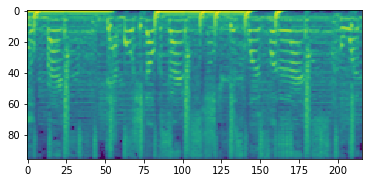

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(spectrograms_dir + 'train/000JCyEkMFumqCZQJAORiQ.png')
imgplot = plt.imshow(img)
plt.show()

In [5]:
time_steps = img.shape[1]
frequency_bands = img.shape[0]

In [6]:
embedding_norm = embedding_model.wv.syn0 #.copy()
#for i, vector in enumerate(embedding_norm):
#    norm = np.linalg.norm(embedding_norm[i], 2)
#    if norm != 0:
#        embedding_norm[i, :] = embedding_norm[i, :] / norm

<ipython-input-6-0206701da2ba>:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  embedding_norm = embedding_model.wv.syn0 #.copy()


In [7]:
from tensorflow.compat.v1.keras.losses import cosine_proximity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU,\
        SeparableConv2D, Convolution2D, MaxPooling2D, BatchNormalization, Flatten

input_shape = (frequency_bands, time_steps, 1)
model_input = Input(input_shape, name='input')
layer = model_input

layer = SeparableConv2D(32, 3, padding="same")(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Dropout(rate=0.2)(layer)

layer = SeparableConv2D(64, 3, padding="same")(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Dropout(rate=0.3)(layer)

layer = SeparableConv2D(128, 3, padding="same")(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Dropout(rate=0.4)(layer)

layer = Flatten()(layer)
layer = Dense(1024)(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization()(layer)
layer = Dropout(rate=0.5)(layer)

layer = Dense(embedding_norm.shape[1])(layer)
model_output = layer
model = Model(model_input, model_output)
model.compile(loss=cosine_proximity, optimizer="adam")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 96, 216, 1)]      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 96, 216, 32)       73        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 216, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 216, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 108, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 108, 32)       0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 48, 108, 64)      

In [8]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
    
def test_model(display_spectrograms = False):
    # guess some similar tracks
    for file in os.listdir(spectrograms_dir + 'test/'):
        track = file[0:-4]
        spectrogram = mpimg.imread(spectrograms_dir + 'test/' + file)
        if display_spectrograms:
            imgplot = plt.imshow(spectrogram)
            plt.show()
        x = np.expand_dims(np.expand_dims(spectrogram, axis=2), axis=0)
        y_pred = model.predict(x)
        y_true = expand_dims(embedding_norm[embedding_model.wv.vocab[track].index], axis=0)
        loss = model.test_on_batch(x, y_true)
        print(f'Tracks most similar to {tracks[track][0]} [{-loss:.2f}] : {tracks[track][1]}')
        most_similar = embedding_model.wv.similar_by_vector(np.squeeze(y_pred, axis=0), topn=3)
        for similar in most_similar:
            if display_spectrograms:
                if os.path.exists(spectrograms_dir + 'train/' + similar[0] + '.png'):
                    spectrogram = mpimg.imread(spectrograms_dir + 'train/' + similar[0] + '.png')
                    imgplot = plt.imshow(spectrogram)
                    plt.show()
                if os.path.exists(spectrograms_dir + 'val/' + similar[0] + '.png'):
                    spectrogram = mpimg.imread(spectrograms_dir + 'val/' + similar[0] + '.png')
                    imgplot = plt.imshow(spectrogram)
                    plt.show()
            print(f'{similar[0]} : {tracks[similar[0]][0]} [{embedding_model.wv.similarity(track, similar[0]):.2f}] : {tracks[similar[0]][1]}')
        print()

def test_model2(display_spectrograms = False):
    # measure cos distance of most and least similar tracks
    for file in os.listdir(spectrograms_dir + 'test/'):
        track = file[0:-4]
        spectrogram = mpimg.imread(spectrograms_dir + 'test/' + file)
        if display_spectrograms:
            imgplot = plt.imshow(spectrogram)
            plt.show()
        x = np.expand_dims(np.expand_dims(spectrogram, axis=2), axis=0)
        y_pred = model.predict(x)
        print(f'Tracks most similar to {tracks[track][0]} : {tracks[track][1]}')
        most_similar = embedding_model.wv.most_similar(positive=[track], topn=5)
        for similar in most_similar:
            filename = spectrograms_dir + f'train/{similar[0]}.png'
            if os.path.exists(filename):
                spectrogram = mpimg.imread(filename)
                if display_spectrograms:
                    imgplot = plt.imshow(spectrogram)
                    plt.show()
                x = np.expand_dims(np.expand_dims(spectrogram, axis=2), axis=0)
                y_pred_similar = model.predict(x)
                cos_distance = np.dot(y_pred[0], y_pred_similar[0])/(np.linalg.norm(y_pred[0])*np.linalg.norm(y_pred_similar[0]))
                print(f'{similar[0]} : {tracks[similar[0]][0]} [{cos_distance:.2f} vs {similar[1]:.2f}] : {tracks[similar[0]][1]}')
        print()
        print(f'Tracks most unlike {tracks[track][0]} : {tracks[track][1]}')
        least_similar = embedding_model.wv.most_similar(negative=[track], topn=5)
        for similar in least_similar:
            filename = spectrograms_dir + f'train/{similar[0]}.png'
            if os.path.exists(filename):
                spectrogram = mpimg.imread(filename)
                if display_spectrograms:
                    imgplot = plt.imshow(spectrogram)
                    plt.show()
                x = np.expand_dims(np.expand_dims(spectrogram, axis=2), axis=0)
                y_pred_similar = model.predict(x)
                cos_distance = np.dot(y_pred[0], y_pred_similar[0])/(np.linalg.norm(y_pred[0])*np.linalg.norm(y_pred_similar[0]))
                print(f'{similar[0]} : {tracks[similar[0]][0]} [{cos_distance:.2f} vs {similar[1]:.2f}] : {tracks[similar[0]][1]}')
        print()

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

class Test(Callback):
    def on_train_begin(self, logs={}):
        self.train_losses = []
        self.val_losses = []
        return
 
    def on_epoch_end(self, epoch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        ax=plt.figure(figsize=(10,4)).gca()
        plt.plot(1+np.arange(len(self.train_losses)), np.array(self.train_losses))
        plt.plot(1+np.arange(len(self.val_losses)), np.array(self.val_losses))
        plt.title('loss', fontsize=18)
        plt.ylabel('loss', fontsize=18)
        plt.legend(['train', 'val'], loc='upper left')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()
        test_model()
        return
    
def spectrogram_generator(directory, label_file, batch_size = 64):
    path = directory + label_file + '/'
    files = []
    for filename in os.listdir(path):
        files.append(filename)
    indices = np.random.permutation(len(files))
    i = 0
    while True:
        # Select files (paths/indices) for the batch
        start = i * batch_size
        end = start + batch_size
        batch = indices[start:end]
        batch_X = np.expand_dims(np.array([mpimg.imread(path + files[j]) for j in batch]), axis=3)
        batch_Y = np.array([embedding_norm[embedding_model.wv.vocab[files[j][:-4]].index] for j in batch])
        i = i + 1
        if end >= len(files):
            i = 0
        yield(batch_X, batch_Y)

Epoch 1/5000
1000/1000 [==============================] - ETA: 0s - loss: -0.7014

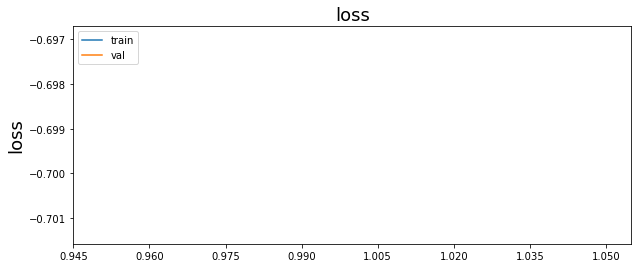

Tracks most similar to Portishead - Glory Box [0.70] : https://p.scdn.co/mp3-preview/1022495d4f4210e2dca85844375715ca286aa0df?cid=194086cb37be48ebb45b9ba4ce4c5936
2lwbjZkzcDkMSf0a4o0Ax1 : Vangelis - Wait For Me [0.29] : https://p.scdn.co/mp3-preview/83e7f5ca6ae70774604d173c5c71d94b0bd9d8a0?cid=194086cb37be48ebb45b9ba4ce4c5936
3RU9FC0SZpEa2a4MqEJXSK : Cate le Bon - Are You With Me Now? [0.34] : 
4K9robUQi9tmUFXfyIKkyQ : WITCH - Strange Dream [0.36] : https://p.scdn.co/mp3-preview/8f95b4c1fcd9186fb5de17df1e2f668421874cd2?cid=194086cb37be48ebb45b9ba4ce4c5936

Tracks most similar to Camilo Sesto - Vivir Así Es Morir de Amor [0.82] : https://p.scdn.co/mp3-preview/9d731886399ba8411787d98b56f93a21c216bae6?cid=194086cb37be48ebb45b9ba4ce4c5936
0pxvHF1GAvgaGHEglfCZDb : Los Galos - Como Deseo Ser Tu Amor [0.86] : 
4S5MEAUeyandJQxJysl5Zd : Manuel Mijares - Soldado Del Amor [0.89] : https://p.scdn.co/mp3-preview/ceb70cb9cede05c6fcb211b5f32b9ef082dc8f03?cid=194086cb37be48ebb45b9ba4ce4c5936
2SAePkgsB

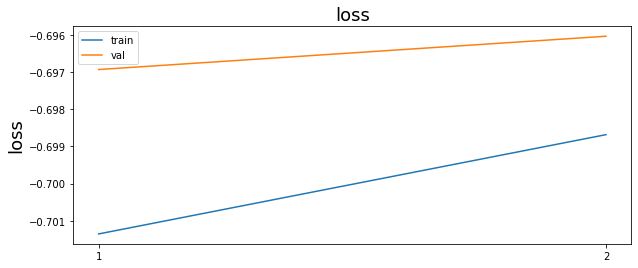

Tracks most similar to Portishead - Glory Box [0.70] : https://p.scdn.co/mp3-preview/1022495d4f4210e2dca85844375715ca286aa0df?cid=194086cb37be48ebb45b9ba4ce4c5936
2lwbjZkzcDkMSf0a4o0Ax1 : Vangelis - Wait For Me [0.29] : https://p.scdn.co/mp3-preview/83e7f5ca6ae70774604d173c5c71d94b0bd9d8a0?cid=194086cb37be48ebb45b9ba4ce4c5936
3RU9FC0SZpEa2a4MqEJXSK : Cate le Bon - Are You With Me Now? [0.34] : 
1jEwv42qfrpH9Pto9UXDHD : The Rolling Stones - Sister Morphine - Remastered [0.35] : 

Tracks most similar to Camilo Sesto - Vivir Así Es Morir de Amor [0.85] : https://p.scdn.co/mp3-preview/9d731886399ba8411787d98b56f93a21c216bae6?cid=194086cb37be48ebb45b9ba4ce4c5936
40TDHz700L8QWiBy4cv3eB : Nana Mouskouri - Se Que Volveras [0.93] : 
2V9cNEWIimaJCXMw4tL6Sk : Roxette - Habla El Corazón (Listen To Your Heart) [0.91] : https://p.scdn.co/mp3-preview/7961992ade8e183e6b8a0a175433285ca57607d1?cid=194086cb37be48ebb45b9ba4ce4c5936
6M1y1gCywRIiHBxXzIweR4 : Tony Ronald - Help, Get Me Some Help [0.92] : htt

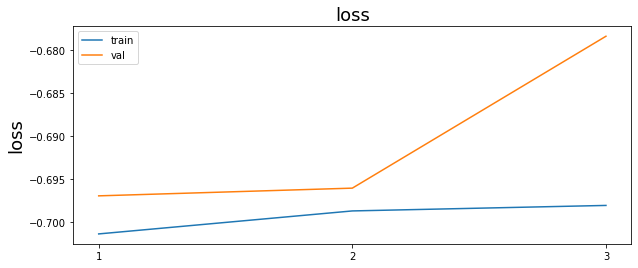

Tracks most similar to Portishead - Glory Box [0.68] : https://p.scdn.co/mp3-preview/1022495d4f4210e2dca85844375715ca286aa0df?cid=194086cb37be48ebb45b9ba4ce4c5936
2A3Mkcpf7t5lz402c2JklE : Boards of Canada - Over The Horizon Radar [0.38] : https://p.scdn.co/mp3-preview/5e1b4e4e9e979a479b42116d825d9393cfd6697b?cid=194086cb37be48ebb45b9ba4ce4c5936
5kEcXZZS97TSNXc6174Ed6 : Julee Cruise - The Nightingale [0.39] : https://p.scdn.co/mp3-preview/d050fee6a3a09a98e5f56c3ee05bcc6b6d29653b?cid=194086cb37be48ebb45b9ba4ce4c5936
4JKF0KZy6Dl4v2QzZpJ5b1 : Marnie - The Hunter [0.37] : https://p.scdn.co/mp3-preview/b3a10b82448dff13ea8ee6d4fa957cb13da6893c?cid=194086cb37be48ebb45b9ba4ce4c5936

Tracks most similar to Camilo Sesto - Vivir Así Es Morir de Amor [0.79] : https://p.scdn.co/mp3-preview/9d731886399ba8411787d98b56f93a21c216bae6?cid=194086cb37be48ebb45b9ba4ce4c5936
1xdMocoG6LHgymfs9lu7tk : Kenny Rogers - What About Me? [0.70] : https://p.scdn.co/mp3-preview/cadbdd81627d128c7098f868d58cd90cf22bc2da?

KeyboardInterrupt: 

In [11]:
model.load_weights(checkpoint_dir + 'speccy')
model.fit_generator(spectrogram_generator(spectrograms_dir, 'train', batch_size=32),
                    steps_per_epoch=1000,
                    epochs=5000,
                    validation_data=spectrogram_generator(spectrograms_dir, 'val', batch_size=32),
                    validation_steps=100,
#                    callbacks=[ModelCheckpoint(checkpoint_dir + 'speccy', save_best_only=True), Test()])
                    callbacks=[Test()])

### Search for a particular song id

In [ ]:
search = 'oasis'
for track in tracks:
    if tracks[track][0].lower().find(search.lower()) != -1 and track in embedding_model.wv.vocab:
        print(f'{track} : {tracks[track][0]} : {tracks[track][1]}')

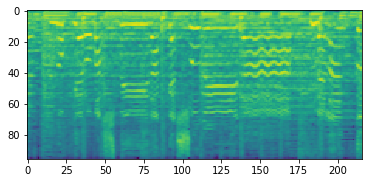

Tracks most similar to Camilo Sesto - Vivir Así Es Morir de Amor [0.86] : https://p.scdn.co/mp3-preview/9d731886399ba8411787d98b56f93a21c216bae6?cid=194086cb37be48ebb45b9ba4ce4c5936
40TDHz700L8QWiBy4cv3eB : Nana Mouskouri - Se Que Volveras [0.93] : 


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


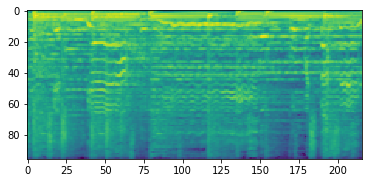

2SAePkgsBoEoPiuIre2k0d : Alvaro Torres - Si Estuvieras Conmigo [0.89] : https://p.scdn.co/mp3-preview/0db702aed7c74dc2575f79f4f17726acfdf49e44?cid=194086cb37be48ebb45b9ba4ce4c5936
0pxvHF1GAvgaGHEglfCZDb : Los Galos - Como Deseo Ser Tu Amor [0.86] : 



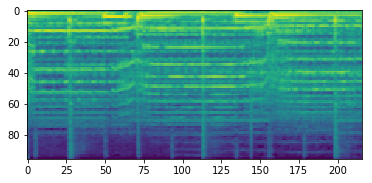

Tracks most similar to Portishead - Glory Box [0.40] : https://p.scdn.co/mp3-preview/1022495d4f4210e2dca85844375715ca286aa0df?cid=194086cb37be48ebb45b9ba4ce4c5936


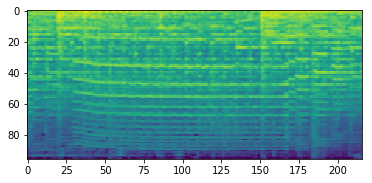

2lwbjZkzcDkMSf0a4o0Ax1 : Vangelis - Wait For Me [0.29] : https://p.scdn.co/mp3-preview/83e7f5ca6ae70774604d173c5c71d94b0bd9d8a0?cid=194086cb37be48ebb45b9ba4ce4c5936


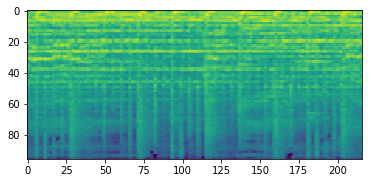

4JKF0KZy6Dl4v2QzZpJ5b1 : Marnie - The Hunter [0.37] : https://p.scdn.co/mp3-preview/b3a10b82448dff13ea8ee6d4fa957cb13da6893c?cid=194086cb37be48ebb45b9ba4ce4c5936
2OCpoUUjefeFnYHnxAF5rY : Tom Waits - Gun Street Girl [0.34] : 



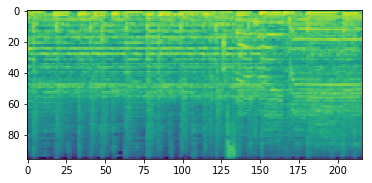

Tracks most similar to Oasis - Wonderwall [0.18] : https://p.scdn.co/mp3-preview/48a875fc1117e0c027571813c3c65b7c4fe52cfa?cid=194086cb37be48ebb45b9ba4ce4c5936


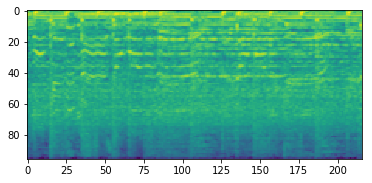

6OK1iexsAs6aDOYZmGI9nD : Bad Religion - The Empire Strikes First [0.08] : https://p.scdn.co/mp3-preview/93e81b5f05eac2b6dd2afee5907f413cf019be2c?cid=194086cb37be48ebb45b9ba4ce4c5936


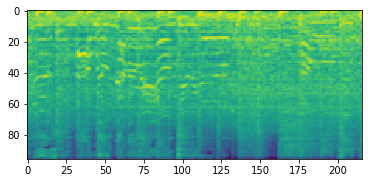

7ie06fqLfm8UnECPYr8Mnh : The Distillers - Dismantle Me [0.09] : https://p.scdn.co/mp3-preview/5d9800e4c6b012a0c51a807c1bb1469984575435?cid=194086cb37be48ebb45b9ba4ce4c5936


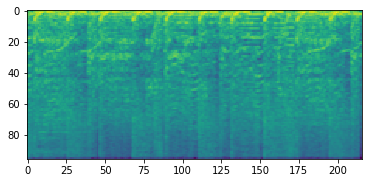

4NFe9UFOhJzdnBTpqnS30P : Rotersand - Exterminate Annihilate Destroy [0.12] : https://p.scdn.co/mp3-preview/a2620e7c1adf4148fcc6734dfe1ffe6a3ab5f6a3?cid=194086cb37be48ebb45b9ba4ce4c5936



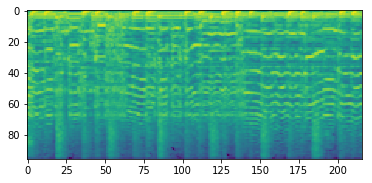

Tracks most similar to Queen - Don't Stop Me Now - Remastered [0.22] : https://p.scdn.co/mp3-preview/5fda76b980c7de5df1e7e9b2d54464665b6029ce?cid=194086cb37be48ebb45b9ba4ce4c5936


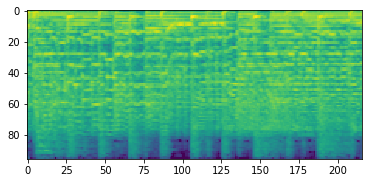

3ROZ4HEoNN92ZuPjf9J6fK : Pat Benatar - Hit Me With Your Best Shot - Remastered [0.19] : https://p.scdn.co/mp3-preview/efc5d6bb5026973efddfe84ea375d0d2f717b82a?cid=194086cb37be48ebb45b9ba4ce4c5936


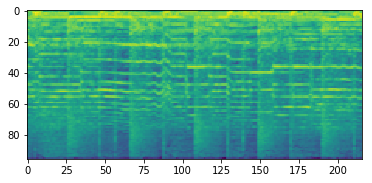

1MHjS8NiajU6sfZWTjr2eu : White Lion - Broken Heart [0.21] : https://p.scdn.co/mp3-preview/1b825c6f586626eb87683237c3d46f4ba845b283?cid=194086cb37be48ebb45b9ba4ce4c5936


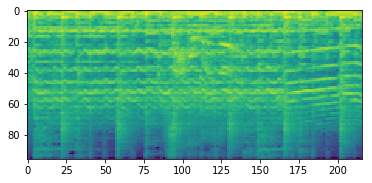

42P2bJSBsKAiwTRoQePTz3 : Billy Idol - Cradle Of Love - Remastered [0.19] : https://p.scdn.co/mp3-preview/f02b825df49a6bad38a2419699e95a75098f9e04?cid=194086cb37be48ebb45b9ba4ce4c5936



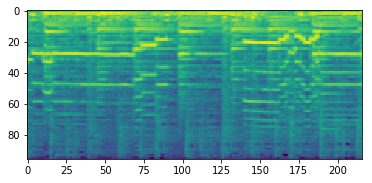

Tracks most similar to John Coltrane - My Favorite Things [0.84] : https://p.scdn.co/mp3-preview/2c2de30a01ea2e1d040bd219ee2436208163f7c5?cid=194086cb37be48ebb45b9ba4ce4c5936


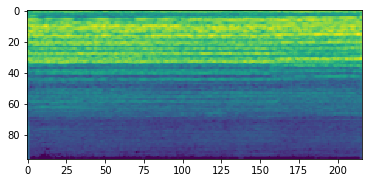

59xohjlL8uhdil8UEMIN76 : John Williams - The Patronus Light [0.81] : https://p.scdn.co/mp3-preview/a606d081e3058213d71d7895474ac089af594918?cid=194086cb37be48ebb45b9ba4ce4c5936


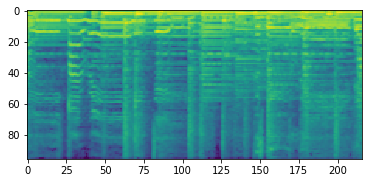

3Mizu9oMBUCm14uctRt2uL : Cassandra Beck - Material Girl [0.84] : https://p.scdn.co/mp3-preview/28a45aa21c93f71268645cd8ab1121c57ea83c5d?cid=194086cb37be48ebb45b9ba4ce4c5936


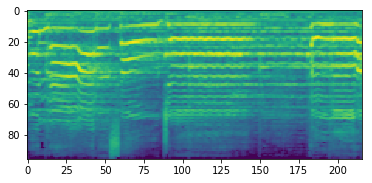

2DuMiTFRTLvIroTxrWBkuf : Bobby Vinton - Mr. Lonely [0.89] : https://p.scdn.co/mp3-preview/1342fb8da30fb5e143220b94c4b7e705bc4bbbeb?cid=194086cb37be48ebb45b9ba4ce4c5936



In [11]:
#model.load_weights(checkpoint_dir + 'speccy')
test_model(True)

In [12]:
test_model2(True)

Output hidden; open in https://colab.research.google.com to view.

### Baseline model

In [ ]:
# find vector in embedding which is (cosine) closest to all the others
# if our model is to be any good, it should at least beat this loss

input_shape = (embedding_norm.shape[1],)
model_input = Input(input_shape, name='input')
layer = model_input
layer = Dense(embedding_norm.shape[1])(layer)
model_output = layer
baseline_model = Model(model_input, model_output)
baseline_model.compile(loss="cosine_proximity", optimizer="adam")

def baseline_generator(batch_size = 64):
    indices = np.random.permutation(embedding_norm.shape[0])
    i = 0
    while True:
        start = i * batch_size
        end = start + batch_size
        batch = indices[start:end]
        # always feed in same inputs
        batch_X = np.array([np.ones(embedding_norm.shape[1]) for j in batch])
        batch_Y = np.array([embedding_norm[j] for j in batch])
        i = i + 1
        if end >= embedding_norm.shape[0]:
            i = 0
        yield(batch_X, batch_Y)
        
baseline_model.fit_generator(baseline_generator(batch_size=128),
                             steps_per_epoch=10000,
                             epochs=1)

x = np.random.rand(1, embedding_norm.shape[1])
y_pred = baseline_model.predict(x)
most_similar = embedding_model.wv.similar_by_vector(np.squeeze(y_pred, axis=0), topn=1)
print(f'{most_similar[0][0]} : {tracks[most_similar[0][0]][0]} : {tracks[most_similar[0][0]][1]}')

Epoch 1/1
10000/10000 [==============================] - 23s 2ms/step - loss: -0.5275
6wWjiM0dGME9srg7xRH98A : SBTRKT - Sanctuary : https://p.scdn.co/mp3-preview/5ac546c1bcbb1d0a6dbeced979dc95361ffc2530?cid=194086cb37be48ebb45b9ba4ce4c5936
